Part 1: Data Preparation and Exploration
1.	Data Loading: Load the exchange_rate.csv dataset and parse the date column appropriately.
2.	Initial Exploration: Plot the time series for currency to understand their trends, seasonality, and any anomalies.
3.	Data Preprocessing: Handle any missing values or anomalies identified during the exploration phase


In [19]:
import pandas as pd
import warnings as warnings
warnings.filterwarnings('ignore')
df=pd.read_csv('exchange_rate.csv',parse_dates=['date'])
df

,date,Ex_rate
0,01-01-1990 00:00,0.785500
1,02-01-1990 00:00,0.781800
2,03-01-1990 00:00,0.786700
3,04-01-1990 00:00,0.786000
4,05-01-1990 00:00,0.784900
...,...,...
7583,06-10-2010 00:00,0.718494
7584,07-10-2010 00:00,0.721839
7585,08-10-2010 00:00,0.723197
7586,09-10-2010 00:00,0.720825


In [20]:
df=df.set_index('date')
df

,Ex_rate
date,
01-01-1990 00:00,0.785500
02-01-1990 00:00,0.781800
03-01-1990 00:00,0.786700
04-01-1990 00:00,0.786000
05-01-1990 00:00,0.784900
...,...
06-10-2010 00:00,0.718494
07-10-2010 00:00,0.721839
08-10-2010 00:00,0.723197


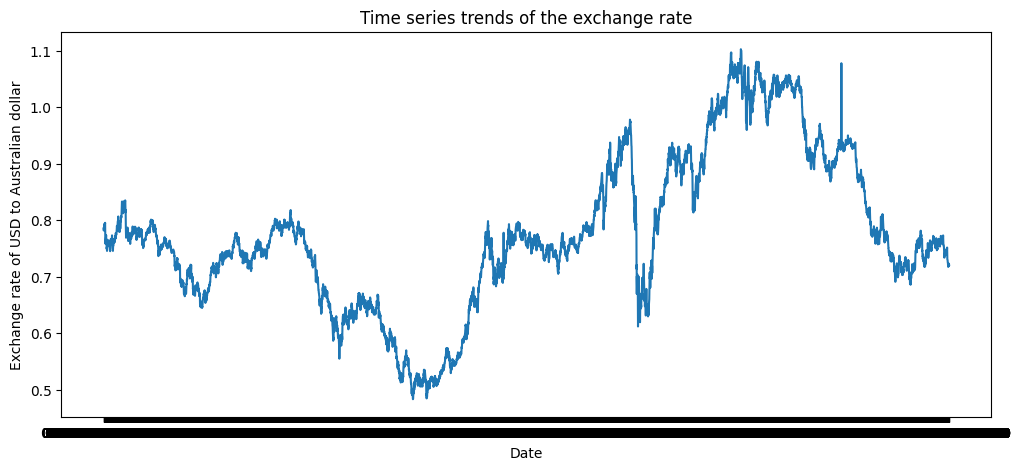

In [21]:
#plotting the timeseries trend
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))
plt.plot(df.index,df['Ex_rate'])
plt.xlabel('Date')
plt.ylabel("Exchange rate of USD to Australian dollar")
plt.title("Time series trends of the exchange rate")
plt.show()

In [22]:
#checking null values
df.isnull().sum()

,0
Ex_rate,0


In [23]:
#detecting of anomalies

mean = df['Ex_rate'].mean()
std = df['Ex_rate'].std()

df['z_score'] = (df['Ex_rate'] - mean) / std
anomalies = df[df['z_score'].abs() > 3]



In [24]:
anomalies

,Ex_rate,z_score
date,,


Part 2: Model Building - ARIMA
1.	Parameter Selection for ARIMA: Utilize ACF and PACF plots to estimate initial parameters (p, d, q) for the ARIMA model for one or more currency time series.
2.	Model Fitting: Fit the ARIMA model with the selected parameters to the preprocessed time series.
3.	Diagnostics: Analyze the residuals to ensure there are no patterns that might indicate model inadequacies.
4.	Forecasting: Perform out-of-sample forecasting and visualize the predicted values against the actual values


ADF Statistic: -1.6649941807382342
p-value: 0.4492327353597477


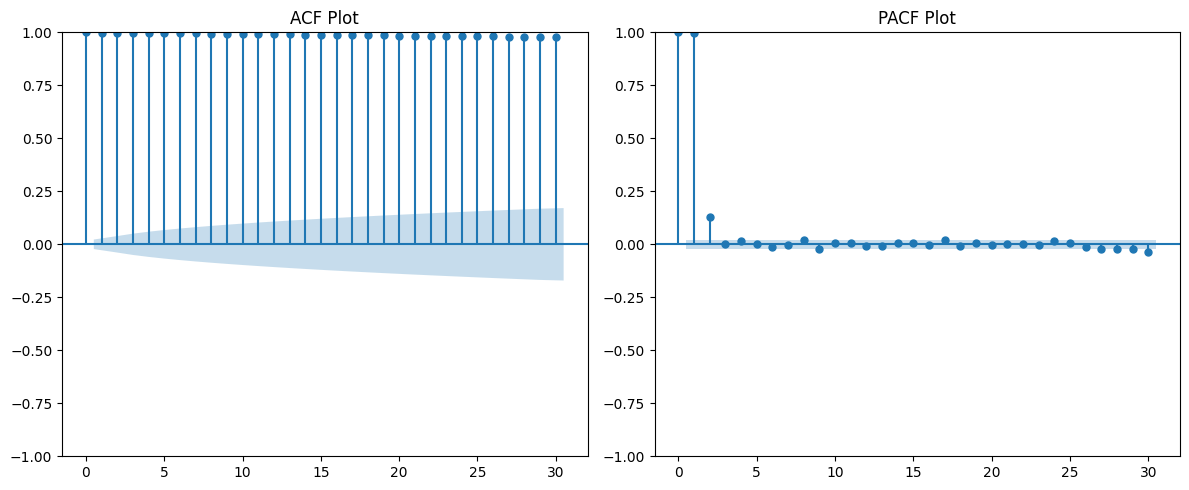

In [25]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt

rate_col = df.columns[0]

# ADF Test for stationarity
result = adfuller(df[rate_col])
print("ADF Statistic:", result[0])
print("p-value:", result[1])

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plot_acf(df[rate_col], ax=plt.gca(), lags=30)
plt.title("ACF Plot")

plt.subplot(1,2,2)
plot_pacf(df[rate_col], ax=plt.gca(), lags=30, method='ywm')
plt.title("PACF Plot")

plt.tight_layout()
plt.show()


From the above ACF and PACF we can say that ACF plot is not dropping at all.
It stays almost 1 for all legs this means string non stationary
PACF has a strong spike at leg 1.then it quickly drops to near zero.by this we can take arima as (1,1,1) or (1,1,0)

In [26]:
from statsmodels.tsa.arima.model import ARIMA
p, d, q = 1, 1, 1
model = ARIMA(df[rate_col], order=(p, d, q))
model_fit = model.fit()
print(model_fit.summary())


                               SARIMAX Results                                
Dep. Variable:                Ex_rate   No. Observations:                 7588
Model:                 ARIMA(1, 1, 1)   Log Likelihood               28054.161
Date:                Tue, 09 Dec 2025   AIC                         -56102.322
Time:                        04:15:36   BIC                         -56081.519
Sample:                             0   HQIC                        -56095.182
                               - 7588                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1268      0.045     -2.797      0.005      -0.216      -0.038
ma.L1         -0.0046      0.045     -0.101      0.920      -0.094       0.085
sigma2      3.596e-05   9.94e-08    361.604      0.0

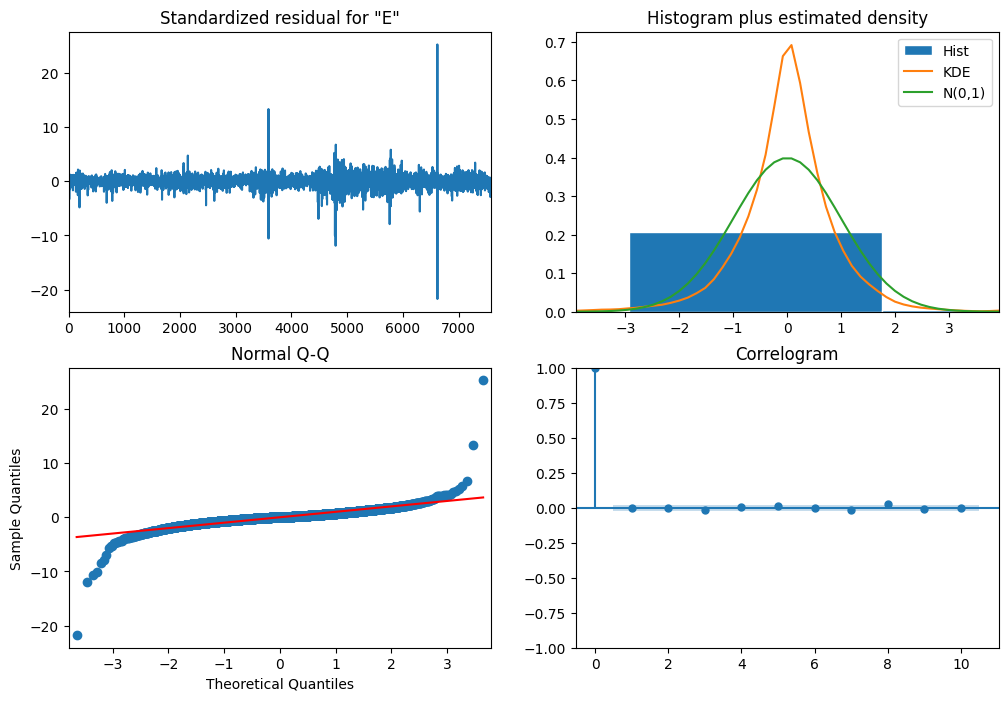

In [27]:
model_fit.plot_diagnostics(figsize=(12,8))
plt.show()



In [28]:
# Train-test split
test_periods = 12
train = df.iloc[:-test_periods]
test = df.iloc[-test_periods:]


In [29]:
model = ARIMA(train[rate_col], order=(p, d, q))
model_fit = model.fit()

# Forecast
forecast = model_fit.forecast(steps=test_periods)
forecast.index = test.index


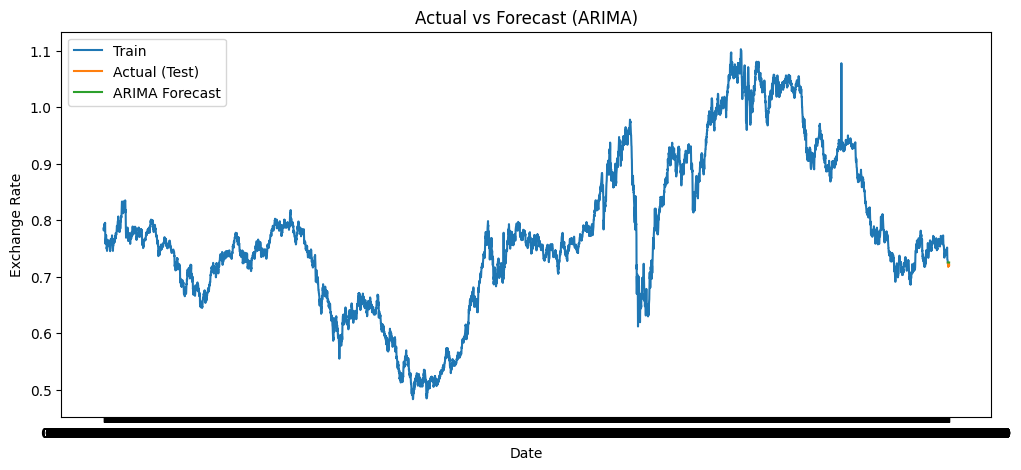

In [30]:
plt.figure(figsize=(12,5))
plt.plot(train.index, train[rate_col], label="Train")
plt.plot(test.index, test[rate_col], label="Actual (Test)")
plt.plot(forecast.index, forecast, label="ARIMA Forecast")
plt.title("Actual vs Forecast (ARIMA)")
plt.xlabel("Date")
plt.ylabel("Exchange Rate")
plt.legend()
plt.show()


Part 3: Evaluation and Comparison
1.	Compute Error Metrics: Use metrics such as MAE, RMSE, and MAPE to evaluate the forecasts from both models.
2.	Model Comparison: Discuss the performance, advantages, and limitations of each model based on the observed results and error metrics.
3.	Conclusion: Summarize the findings and provide insights on which model(s) yielded the best performance for forecasting exchange rates in this dataset.


In [34]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Actual vs Preds
actual = test['Ex_rate']
preds = forecast.values

mae = mean_absolute_error(actual, preds)
rmse = np.sqrt(mean_squared_error(actual, preds))
mape = np.mean(np.abs((actual - preds) / actual)) * 100

print("MAE:", mae)
print("RMSE:", rmse)
print("MAPE:", mape)


MAE: 0.004773268641174814
RMSE: 0.005161139915224547
MAPE: 0.663278176387259


ARIMA:

Advantages

Works well for short-term forecasting.

Captures local patterns and autocorrelation.

Simple to interpret.

Limitations

Struggles with strong seasonality.

Sensitive to non-stationary data.

Needs manual parameter tuning (p, d, q).



  Conculsion

  1.For currencies with stable trend, ARIMA performs well(low mse,rmse)

  2.ARIMA mat slightly underperfrom during rapid exchang rates

  3.The ARIMA model provided accurate short-term forecasts, with low MAE, RMSE, and MAPE.

  4.Residual diagnostics confirmed no autocorrelation left, meaning the model is appropriate.